In [1]:
import torch
import torch.nn as nn
import TorchData
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=3):
        super(TransformerAutoencoder, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, input_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [24]:
class NoisyDataset(Dataset):
    def __init__(self, t_dim, x_dim, y_dim, num_samples=1000, n_remove=10, noise_p=0.1, time_mode='random'):
        self.num_samples = num_samples
        self.torchData = TorchData.TorchData(t_dim, x_dim, y_dim, n_remove, noise_p, time_mode)
        self.data = self.torchData.signal_time
        self.noisy_data = self.torchData.sn_time
        self.num_samples = self.data.shape[0]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return torch.tensor(self.noisy_data[idx], dtype=torch.float32), torch.tensor(self.data[idx], dtype=torch.float32)


In [25]:
def train_model(model, dataloader, epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for noisy_data, clean_data in dataloader:
            optimizer.zero_grad()
            output = model(noisy_data)
            loss = criterion(output, clean_data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.6f}")

In [26]:
dataset = NoisyDataset(10, 40, 20)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [31]:
model = TransformerAutoencoder(input_dim=20)
train_model(model, dataloader, epochs=3000)

C:\Users\CATFOOL\AppData\Local\Temp\ipykernel_23016\3292217314.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.noisy_data[idx], dtype=torch.float32), torch.tensor(self.data[idx], dtype=torch.float32)


Epoch [1/3000], Loss: 2326.335449
Epoch [2/3000], Loss: 2152.598267
Epoch [3/3000], Loss: 2266.076660
Epoch [4/3000], Loss: 2062.599365
Epoch [5/3000], Loss: 2031.921814
Epoch [6/3000], Loss: 1927.355225
Epoch [7/3000], Loss: 2125.491089
Epoch [8/3000], Loss: 1946.050659
Epoch [9/3000], Loss: 2147.308594
Epoch [10/3000], Loss: 1996.147156
Epoch [11/3000], Loss: 2109.061646
Epoch [12/3000], Loss: 1957.240112
Epoch [13/3000], Loss: 2001.103455
Epoch [14/3000], Loss: 2060.091919
Epoch [15/3000], Loss: 2285.007568
Epoch [16/3000], Loss: 1823.954346
Epoch [17/3000], Loss: 2468.189026
Epoch [18/3000], Loss: 2474.495544
Epoch [19/3000], Loss: 1934.103394
Epoch [20/3000], Loss: 1883.580078
Epoch [21/3000], Loss: 1918.896362
Epoch [22/3000], Loss: 1837.674683
Epoch [23/3000], Loss: 1793.582825
Epoch [24/3000], Loss: 1824.579956
Epoch [25/3000], Loss: 1881.202576
Epoch [26/3000], Loss: 2068.015503
Epoch [27/3000], Loss: 2197.686279
Epoch [28/3000], Loss: 1892.013794
Epoch [29/3000], Loss: 2129.9

C:\Users\CATFOOL\AppData\Local\Temp\ipykernel_23016\3292217314.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.noisy_data[idx], dtype=torch.float32), torch.tensor(self.data[idx], dtype=torch.float32)


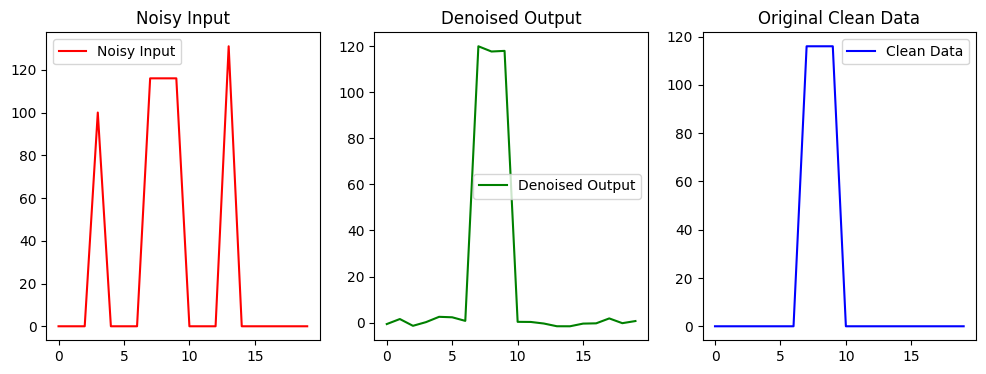

In [33]:
import matplotlib.pyplot as plt

# Get a batch of test data
noisy_sample, clean_sample = next(iter(dataloader))
noisy_sample, clean_sample = noisy_sample[0].numpy(), clean_sample[0].numpy()

noisy_sample_tensor = torch.tensor(noisy_sample, dtype=torch.float32).unsqueeze(0)  # Add batch dim

# Get model output (denoised sample)
model.eval()
with torch.no_grad():
    denoised_sample = model(noisy_sample_tensor).squeeze(0).numpy()  # Remove batch dim for plotting

# Plot before and after
plt.figure(figsize=(12, 4))

# Noisy input
plt.subplot(1, 3, 1)
plt.plot(noisy_sample, label="Noisy Input", color='r')
plt.title("Noisy Input")
plt.legend()

# Denoised output
plt.subplot(1, 3, 2)
plt.plot(denoised_sample, label="Denoised Output", color='g')
plt.title("Denoised Output")
plt.legend()

# Original clean data
plt.subplot(1, 3, 3)
plt.plot(clean_sample, label="Clean Data", color='b')
plt.title("Original Clean Data")
plt.legend()

plt.show()